In [41]:
import parse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import parse

import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

# no-rep => 202, 188 -> 1st, 2nd
# rep => 166, 168 -> 1st, 2nd
# ens1f0 => network
# dev8-16 => disk
# all => cpu

# Context & Motivation

Contexte de stockage distribué où les requetes d'I/O vers les differents disques durs du cluster de stockage sont simplement reparties

Entrainant une impredictabilité des performances.

### Expes pour valider notre motivation

Environnement:

![test](image.drawio.png)
- 800Go disque dur
- 16 cores x 3MHz
- 125Go RAM
- 25Gbps network throughput

Systèmes de stockage etudiés:
- GlusterFS
- Ceph

Workload:
- fio dans une VM de 50G d'image (70% read, 30% write)
- Vm of 8 vCPUs and 4Go de RAM

Deroulement des expes:

- lancer un seul workload sur une machine du cluster
- lancer plusieurs workload sur une autre machine (varier le nombre de workloads entre 1 et 10)

Expes et Observations:

Durant l'expe on observe et on recup' les metriques suivantes avec `sar`:
- taux d'utilisation des disques de chaque machine du cluster
- taux d'utilisation du reseau
- taux du CPU

# Gluster Distrib

In [44]:
#dirr="/home/nivek/Workspace/distristorage/cloudlabs/data-gluster-well/"
#dirr="/home/nivek/Workspace/distristorage/cloudlabs/data-disperse-read-hash-mode-5/"
dirr="/home/nivek/Workspace/distristorage/cloudlabs/data-gluster-rocks-read-5/"
dirr="/home/nivek/Workspace/distristorage/cloudlabs/data-gluster-fio-snap20-1netdelay5/"

node0 = "139"
node1 = "146"
datas={}
for f in os.listdir(dirr):
    try:
        ind, nwork =parse.parse("sar_res_amd{:d}.utah.cloudlab.us-{:d}", f)
    except:
        continue
    datas[str(ind)+"-"+str(nwork)] = {"network":[], "disk":[], "cpu":[]}
    with open(dirr+f, "r") as fd:
        lines = fd.readlines()
        for line in lines:
            if "ens1f0" in line:
                h = float(line.split()[-1])
                datas[str(ind)+"-"+str(nwork)]["network"] += [h]
            if "all" in line:
                # 2 => application level
                # 4 => system level
                h = float(line.split()[4])+float(line.split()[2])
                datas[str(ind)+"-"+str(nwork)]["cpu"] += [h]
            if "dev8-16" in line: # try with dev8-16 if it's now working with dev8-0
                h = float(line.split()[-1]) ## real column for disk usage
                #h = float(line.split()[-2]) ## column for queue length
                datas[str(ind)+"-"+str(nwork)]["disk"] += [h]


<IPython.core.display.Javascript object>


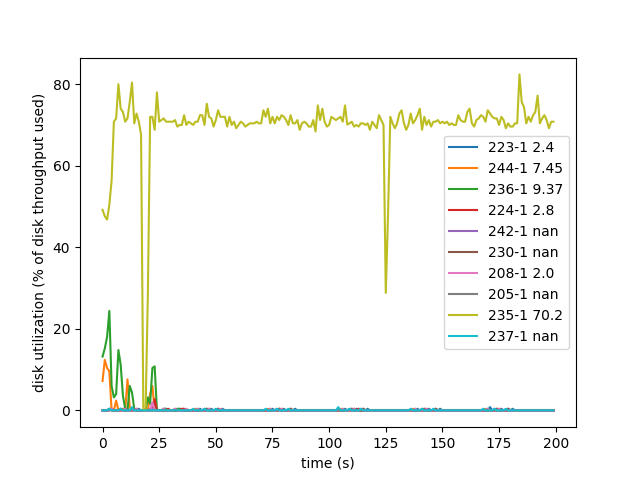

223-1 2.4
244-1 7.45
236-1 9.375
224-1 2.8
242-1 nan
230-1 nan
208-1 2.0
205-1 nan
235-1 70.23484848484848
237-1 nan


In [45]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if k[-2:] == "-1":
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["disk"][:]
        del t[-1]
        del t[-200:]
        tmp = []
        for i in range(len(t)):
            if t[i] > 1: tmp += [t[i]]
        l = ax.plot(t, label=lab+" "+str(np.mean(tmp))[:4])
        print(lab, np.mean(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

ax.set_ylabel("disk utilization (% of disk throughput used)")
ax.set_xlabel("time (s)")

plt.show()

<IPython.core.display.Javascript object>


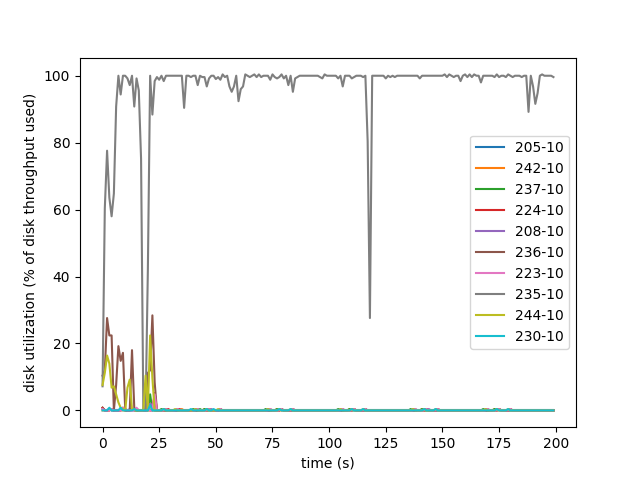

205-10 nan
242-10 nan
237-10 4.8
224-10 5.2
208-10 1.8
236-10 16.0
223-10 4.8
235-10 100.0
244-10 9.2
230-10 1.6


In [46]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["disk"][:]
        del t[-1]
        del t[-200:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 1: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

ax.set_ylabel("disk utilization (% of disk throughput used)")
ax.set_xlabel("time (s)")

plt.show()

<IPython.core.display.Javascript object>


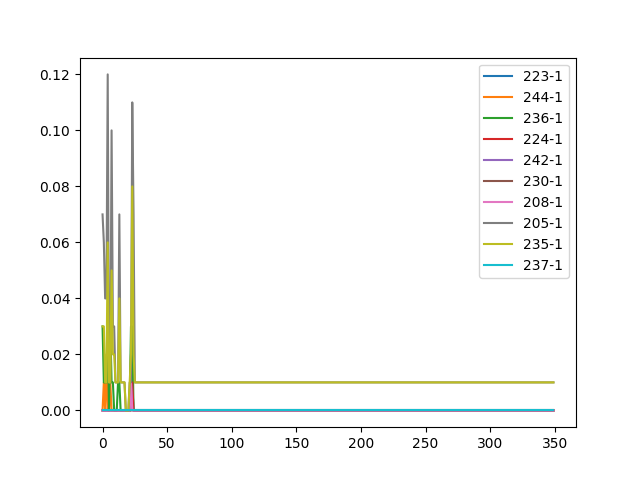

223-1 nan
244-1 nan
236-1 nan
224-1 nan
242-1 nan
230-1 nan
208-1 nan
205-1 nan
235-1 nan
237-1 nan


In [47]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if k[-2:] == "-1":
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["network"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0.5: tmp += [t[i]]
        print(lab, np.mean(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


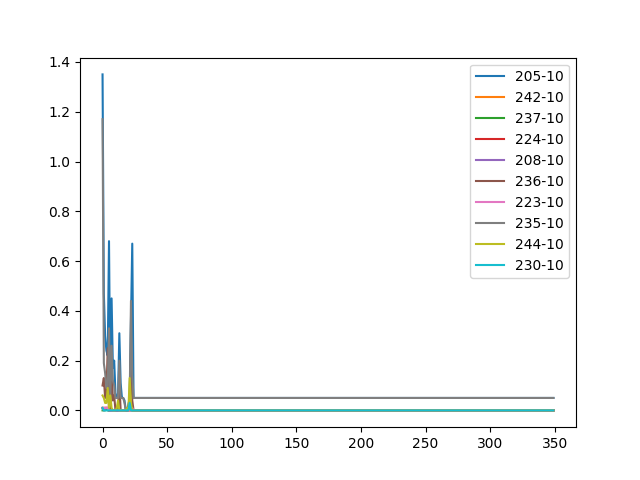

205-10 0.68
242-10 nan
237-10 nan
224-10 nan
208-10 nan
236-10 nan
223-10 nan
235-10 1.17
244-10 nan
230-10 nan


In [48]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["network"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0.5: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


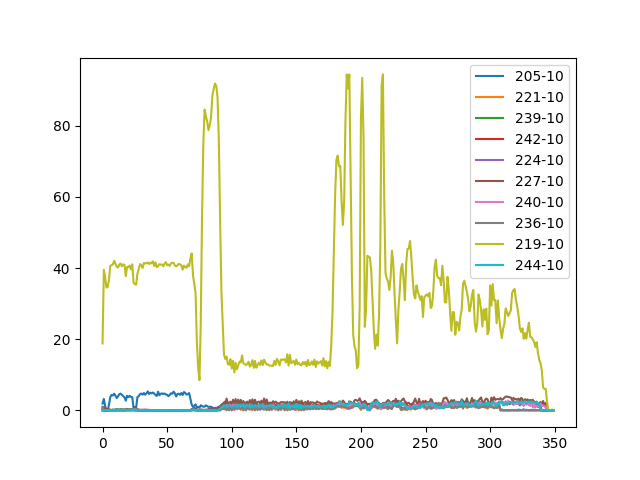

205-10 1.18
221-10 0.63
239-10 1.35
242-10 1.52
224-10 1.16
227-10 2.09
240-10 1.19
236-10 0.63
219-10 30.89
244-10 1.4


In [20]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    #if k[-2:] == "-1":
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["cpu"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

# Gluster replication

In [10]:
# 166, 168

dirr="/home/nivek/Workspace/distristorage/cloudlabs/data-gluster-disperse/"

node0 = "220"
node1 = "181"
datas={}
for f in os.listdir(dirr):
    try:
        ind, nwork =parse.parse("sar_res_amd{:d}.utah.cloudlab.us-{:d}", f)
    except:
        continue
        
    datas[str(ind)+"-"+str(nwork)] = {"network":[], "disk":[], "cpu":[]}
    with open(dirr+f, "r") as fd:
        lines = fd.readlines()
        for line in lines:
            if "ens1f0" in line:
                h = float(line.split()[-1])
                datas[str(ind)+"-"+str(nwork)]["network"] += [h]
            if "all" in line:
                # 2 => application level
                # 4 => system level
                h = float(line.split()[4])+float(line.split()[2])
                datas[str(ind)+"-"+str(nwork)]["cpu"] += [h]
            if "dev8-16" in line:
                h = float(line.split()[-1])
                datas[str(ind)+"-"+str(nwork)]["disk"] += [h]

<IPython.core.display.Javascript object>


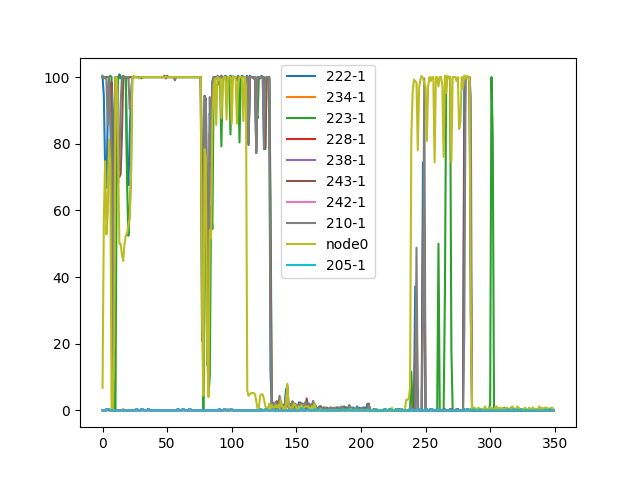

222-1 100.0
234-1 nan
223-1 100.0
228-1 nan
238-1 nan
243-1 100.0
242-1 nan
210-1 100.0
node0 98.8
205-1 nan


In [11]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if k[-2:] == "-1":
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["disk"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 1: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


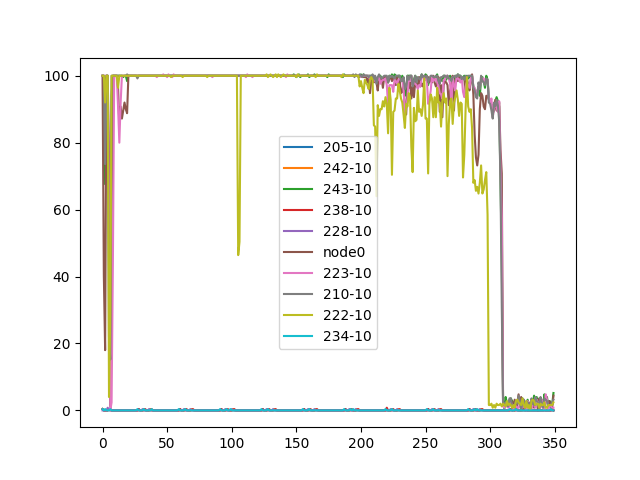

205-10 nan
242-10 nan
243-10 100.0
238-10 nan
228-10 nan
node0 100.0
223-10 100.0
210-10 100.0
222-10 100.0
234-10 nan


In [12]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["disk"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 1: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


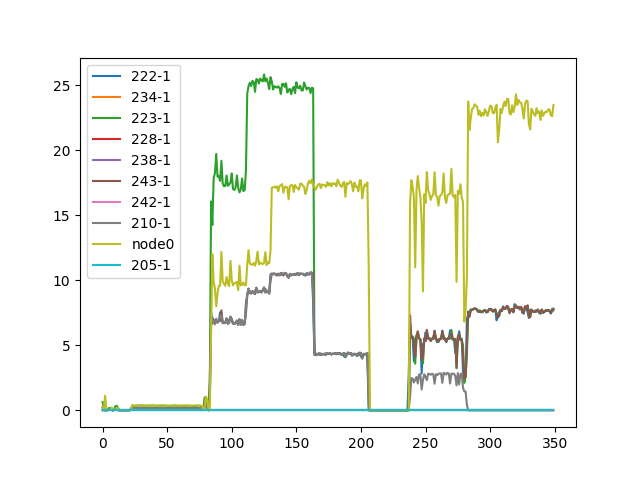

222-1 5.5649999999999995
234-1 nan
223-1 5.6
228-1 nan
238-1 nan
243-1 5.54
242-1 nan
210-1 2.84
node0 16.56
205-1 nan


In [13]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if k[-2:] == "-1":
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["network"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


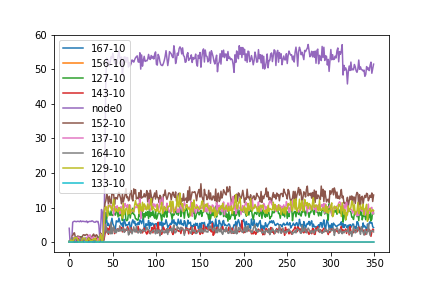

167-10 4.98
156-10 0.030000000000000002
127-10 8.254999999999999
143-10 3.3
node0 52.805
152-10 13.03
137-10 9.83
164-10 3.19
129-10 9.6
133-10 nan


In [284]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["network"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


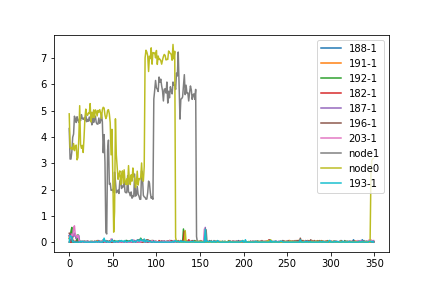

188-1 0.03
191-1 0.03
192-1 0.03
182-1 0.03
187-1 0.03
196-1 0.03
203-1 0.03
node1 2.685
node0 3.365
193-1 0.03


In [214]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if k[-2:] == "-1":
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["cpu"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

<IPython.core.display.Javascript object>


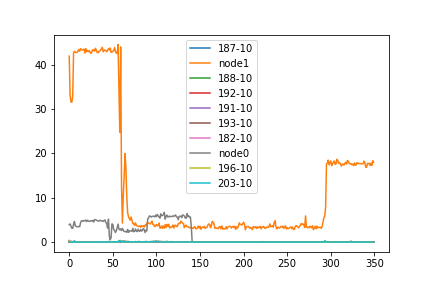

187-10 0.03
node1 3.88
188-10 0.03
192-10 0.03
191-10 0.03
193-10 0.03
182-10 0.03
node0 3.5
196-10 0.03
203-10 0.03


In [215]:
%matplotlib notebook

fig, ax = plt.subplots()
lines= []

for k in datas:
    if "-10" in k:
        lab = "node0" if node0 in k else "node1" if node1 in k else k
        t = datas[k]["cpu"][:]
        del t[-1]
        del t[-50:]
        l = ax.plot(t, label=lab)
        tmp = []
        for i in range(len(t)):
            if t[i] > 0: tmp += [t[i]]
        print(lab, np.median(tmp))
        lines.append(l[0])
        
leg = ax.legend()

lined = {}  # Will map legend lines to original lines.
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # Enable picking on the legend line.
    legline.set_pickradius(2)
    lined[legline] = origline

def on_pick(event):
    # On the pick event, find the original line corresponding to the legend
    # proxy line, and toggle its visibility.
    print(5)
    legline = event.artist
    origline = lined[legline]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    # Change the alpha on the line in the legend so we can see what lines
    # have been toggled.
    legline.set_alpha(1.0 if visible else 0.2)
    fig.canvas.draw()

fig.canvas.mpl_connect('pick_event', on_pick)

plt.show()

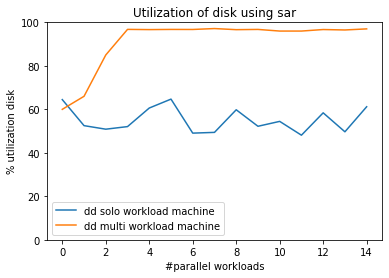

In [65]:
#network_utilization = [9, 17, 26, 28, 30 ....m 20.] # on distant disk
#network_utilization = [9*7, 5*17, 9, 13, 9]
#gluster/replicate one

dd_glus_read_disk1_util = [60, 66, 85, 96.77, 96.67, 96.75, 96.73, 97.15, 96.64, 96.75, 96, 96, 96.7, 96.5, 97]
dd_glus_read_disk2_util = [64.47, 52.5, 50.87, 52.06, 60.6, 64.7, 49.06, 49.4, 59.8, 52.21, 54.46, 48.11, 58.39, 49.67, 61.19]

dd_glus_read_disk1_thr = [457, 472, 356, 274, 217, 195, 181, 149, 131, 113, 111, 106, 127, 111, 76.]
dd_glus_read_disk2_thr = [452, 586, 605, 578, 417, 387, 585, 565, 395, 584, 549, 599, 407, 579, 393]

fio_glus_read_disk1_util = [69, 70, 69, 70, 71, 72, 71, 89, 95.88, 96.57, 95.74, 95.71, 95.51, 95.41, 96.88]

#gluster/no replicate

dd_glus_read_disk1_util2 = [60, 69, 75, 77, 81.41, 82.43, 85.12, 90.4, 90.5, 91.6, 91.6, 92.3, 93.5, 94.6, 96]
dd_glus_read_disk2_util2 = [69, 75, 77, 81.41, 82.43, 85.12, 90.4, 90.5, 91.6, 91.6, 92.3, 93.5, 94.6, 96.5, 97.5]

#ceph
dd_ceph_read_disk1_util = [64, 79, 80, 90, 92, 94, 94, 95]
dd_ceph_read_disk2_util = [51, 60, 69, 75, 77, 81.41, 82.43, 85.12]

plt.plot(dd_glus_read_disk2_util, label="dd solo workload machine")
plt.plot(dd_glus_read_disk1_util, label="dd multi workload machine")

plt.xlabel('#parallel workloads')
plt.ylabel('% utilization disk')
plt.title("Utilization of disk using sar")
plt.ylim([0, 100])
plt.legend();
plt.show()

sar15o 97.53
sar5o 49.05
sar7o 49.78
sar1o 61.61


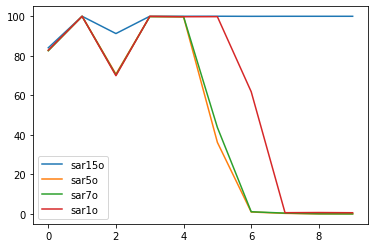

sar5_ 96.33
sar15_ 96.5
sar1_ 0.03
sar7_ 96.23


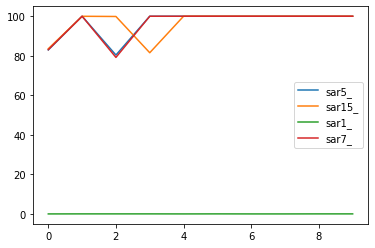

sar70 66.92
sar150 86.73
sar50 48.59
sar10 50.67


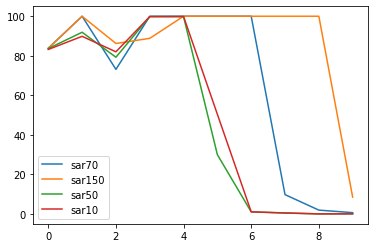

In [54]:
import glob

# 0 => solo-workload disk
# o => multi-workload disk
# _ => no-workload disk
sar = {}

for char in "o_0":
    for f in glob.glob("sar*"+char):
        sar[f] = []
        with open(f, "r") as fd:
            lines = fd.readlines()
            for line in lines:
                if "dev8-16" in line:
                    sar[f] += [float(line.split()[-1])]
            print(f, sar[f][-1])
            del sar[f][-1]
        # plotting
        plt.plot(sar[f], label=f)
    plt.legend()
    plt.show()


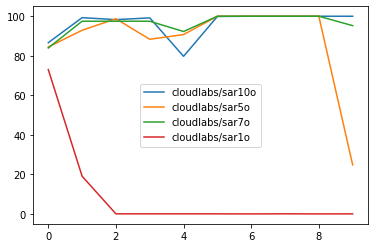

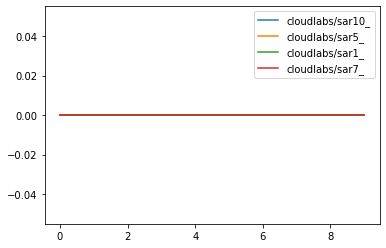

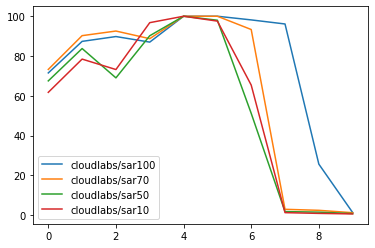

In [53]:
import glob

# 0 => solo-workload disk
# o => multi-workload disk
# _ => no-workload disk
sar = {}

for char in "o_0":
    for f in glob.glob("cloudlabs/sar*"+char):
        sar[f] = []
        with open(f, "r") as fd:
            lines = fd.readlines()
            for line in lines:
                if "dev8-16" in line:
                    sar[f] += [float(line.split()[-1])]
            del sar[f][-1]
        # plotting
        plt.plot(sar[f], label=f)
    plt.legend()
    plt.show()

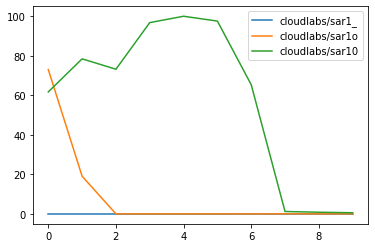

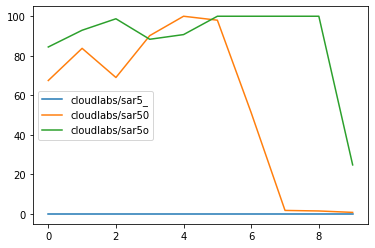

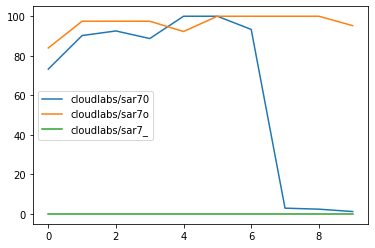

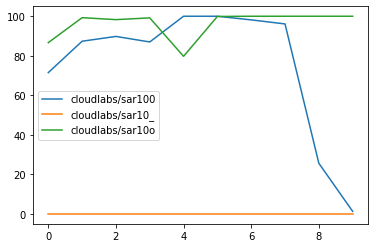

In [46]:
# par length

import glob

# 0 => solo-workload disk
# o => multi-workload disk
# _ => no-workload disk
sar = {}

for char in ["1", "5", "7", "10"]:
    for f in glob.glob("cloudlabs/sar"+char+"?"):
        sar[f] = []
        with open(f, "r") as fd:
            lines = fd.readlines()
            for line in lines:
                if "dev8-16" in line:
                    sar[f] += [float(line.split()[-1])]
            del sar[f][-1]
        # plotting
        plt.plot(sar[f], label=f)
    plt.legend()
    plt.show()

# Context & Motivation

Contexte de stockage distribué où les requetes d'I/O vers les differents disques durs du cluster de stockage sont simplement reparties

Entrainant une impredictabilité des performances.

### Expes pour valider notre motivation

Environnement:

![test](image.drawio.png)

Workload:
- fio avec 70% de lecture et ecriture

Deroulement des expes:

- lancer un seul workload sur une machine du cluster
- lancer plusieurs workload sur une autre machine 

Expes et Observations:

Durant l'expe on observe et on recup' les metriques suivantes avec `sar`:
- taux d'utilisation des disques du cluster ( disque de la machine avec le workload solitaire, de la machine avec plusieurs workloads et d'une machine laissée libre )
- taux d'utilisation du reseau

In [74]:
# tous les details sur les PCs et les workloads
# taux cpu autres machines

## Gluster: Variation of disk usage according to #workloads running on 

In [145]:
# add gluster daemon disk utilization
# VM without gluster (distinct qemu usage and gluster usage)

# easy solution: soft migration with chain creation.

plt.plot(dd_glus_read_disk2_util, label="fio solo-workload disk machine")
plt.plot(dd_glus_read_disk1_util, label="fio multi-workload disk machine")

plt.xlabel('#parallel workloads')
plt.ylabel('% utilization disk')
plt.title("Utilization of disk using sar")
plt.ylim([0, 100])
plt.legend();
plt.show()

plt.plot(dd_glus_read_disk2_util2, label="fio solo-workload disk machine")
plt.plot(dd_glus_read_disk1_util2, label="fio multi-workload disk machine")

plt.xlabel('#parallel workloads')
plt.ylabel('% utilization disk')
plt.title("Utilization of disk using sar")
plt.ylim([0, 100])
plt.legend();
plt.show()

NameError: name 'dd_glus_read_disk2_util' is not defined

## Ceph

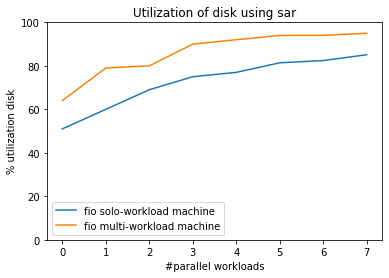

In [66]:
plt.plot(dd_ceph_read_disk2_util, label="fio solo-workload machine")
plt.plot(dd_ceph_read_disk1_util, label="fio multi-workload machine")

plt.xlabel('#parallel workloads')
plt.ylabel('% utilization disk')
plt.title("Utilization of disk using sar")
plt.ylim([0, 100])
plt.legend();
plt.show()

# Gluster: Evolution of disk utilization `during` workload

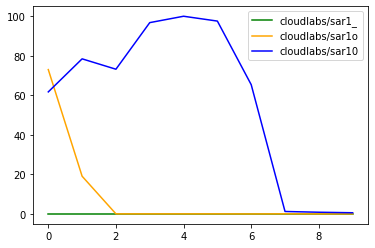

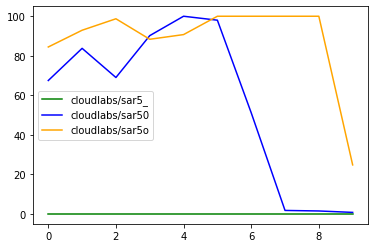

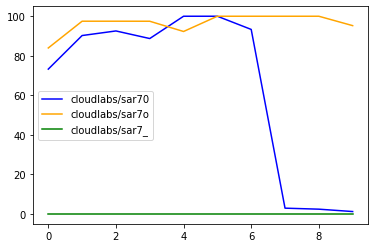

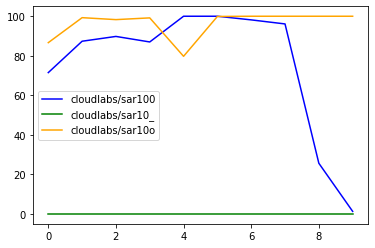

In [77]:
import glob

# 0 => solo-workload disk
# o => multi-workload disk
# _ => no-workload disk
sar = {}
colors= {"0":"blue", "o":"orange", "_":"green"}

for char in ["1", "5", "7", "10"]:
    i=0
    for f in glob.glob("cloudlabs/sar"+char+"?"):
        sar[f] = []
        with open(f, "r") as fd:
            lines = fd.readlines()
            for line in lines:
                if "dev8-16" in line:
                    sar[f] += [float(line.split()[-1])]
            del sar[f][-1]
        # plotting
        plt.plot(sar[f], label=f, color=colors[f[-1]])
        i+=1
    plt.legend()
    plt.show()

## Limites

- Pertinence de l'expes ( que 20 noeuds ici)
- Est-ce un vrai problème (bcp de papiers en parlent, mais très peu travaillent dessus)
- Pertinence du problème (utilisation de systeme existant par OutScale) ?